In [129]:
import torch
import torch.fft as fft
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import warnings
%matplotlib notebook

warnings.filterwarnings('ignore')
def imscatter(X, images, zoom=2):
    ax = plt.gca()
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    scale_factor = 10
    plt.xlim(xmin * scale_factor, xmax * scale_factor)
    plt.ylim(ymin * scale_factor, ymax * scale_factor)

    for i, img in enumerate(images):
        x, y = X[i, :]
        im = OffsetImage(img.numpy().squeeze(), zoom=zoom)
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(X)
    ax.autoscale()
    ax.set_xticks([])
    ax.set_yticks([])

    
def plotMNIST(images, zoom = 2):
    N = len(images)
    dgrid = int(np.ceil(np.sqrt(N)))
    ex = np.arange(dgrid)
    x, y = np.meshgrid(ex, ex)
    X = np.zeros((N, 2))
    X[:, 0] = x.flatten()[0:N]
    X[:, 1] = y.flatten()[0:N]
    imscatter(X, images, zoom)

        
class TransformLowPass(object):

    def __init__(self):
        self.fft = True
        self.lowpass = True
        self.flatten = True
        rows, cols = 28,28
        crow, ccol = int(rows / 2), int(cols / 2)
        mask = np.zeros((rows, cols), np.uint8)
        r = 6
        center = [crow, ccol]
        x, y = np.ogrid[:rows, :cols]
        mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
        mask[mask_area] = 1
        self.mask = torch.from_numpy(mask).bool()
#         print(torch.masked_select(self.mask,self.mask).shape)
        
    def __call__(self, img):
        if self.fft:
            img = fft.fftshift(fft.fft2(img))
        if self.lowpass:
            img = img*self.mask
        if self.flatten:
            img = torch.masked_select(img,self.mask)
        return torch.abs(img)

In [141]:

epochs = 0
batch_size = 100
lr = .0001
# ,transforms.Normalize((.5,.5,.5),(.5,.5,.5)),
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,),(.5,),),TransformLowPass()])

train_dataset = torchvision.datasets.MNIST(root="./data",train=True, download=True,transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data",train=False, download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')
classes = ("T-shirt", "Trouser", "Pullover", "Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot")

device = torch.device('cpu')


In [142]:
images, labels = iter(train_loader).next()
images[0].shape
# print(images[0])

torch.Size([113])

In [143]:
# plotMNIST(images,zoom = 2)

In [144]:
# from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
# from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

# class ComplexNeuralNet(nn.Module):
    
#     def __init__(self):
#         super(NeuralNet, self).__init__()
#         self.fc1 = Linear(197,10)   
# #         self.fc2 = ComplexLinear(100,10)   
# #         self.fc3 = ComplexLinear(100,10)   
             
#     def forward(self,x):
#         x = complex_relu(self.fc1(x))
# #         x = self.fc3(x)
#         x = x.abs()
#         return x

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(113,100)
        self.fc2 = nn.Linear(100,10)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
model = NeuralNet().to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

12410


In [145]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
l = []
for epoch in range(1):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(images), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item())
            )
            l.append(loss.item())
            


# Test
with torch.no_grad():
    n_correct=0 
    n_samples = 0
    n_class_correct = [0 for _ in range(10)]
    n_class_samples = [0 for _ in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        
        _,predicted = torch.max(output,1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            
            if (label == pred):
                n_class_correct[label]+=1
            n_class_samples[label] += 1

acc = 100.0 *n_correct / n_samples
print(f"Accuracy of network: {acc}")
for i in range(10):
    acc = 100.0 *n_class_correct[i] / n_class_samples[i]
    print(f"Accuracy of class {classes[i]}: {acc}")
    

Train Epoch:   0 [     0/ 60000 (  0%)]	Loss: 24.290306
Train Epoch:   0 [ 10000/ 60000 ( 17%)]	Loss: 2.746274
Train Epoch:   0 [ 20000/ 60000 ( 33%)]	Loss: 2.067437
Train Epoch:   0 [ 30000/ 60000 ( 50%)]	Loss: 1.891783
Train Epoch:   0 [ 40000/ 60000 ( 67%)]	Loss: 1.592212
Train Epoch:   0 [ 50000/ 60000 ( 83%)]	Loss: 1.541131
Accuracy of network: 61.27
Accuracy of class T-shirt: 66.53061224489795
Accuracy of class Trouser: 97.88546255506608
Accuracy of class Pullover: 60.27131782945737
Accuracy of class Dress: 44.257425742574256
Accuracy of class Coat: 69.14460285132382
Accuracy of class Sandal: 58.74439461883408
Accuracy of class Shirt: 37.47390396659708
Accuracy of class Sneaker: 68.48249027237354
Accuracy of class Bag: 58.2135523613963
Accuracy of class Ankle boot: 45.78790882061447


<IPython.core.display.Javascript object>


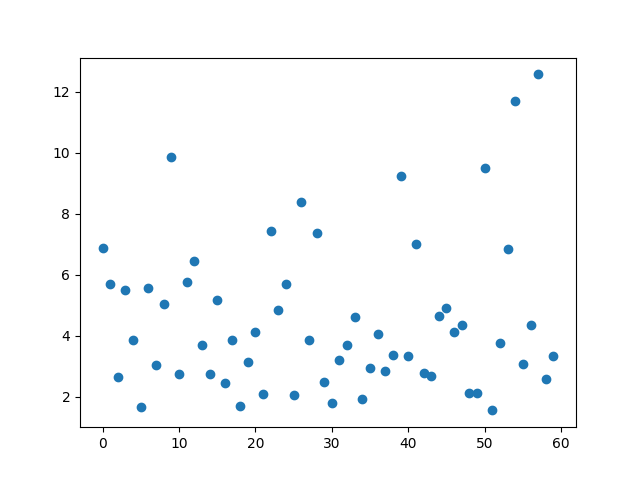

In [105]:
plt.scatter([i for i in range(len(l))],l)